In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

from scipy.cluster import hierarchy
import scipy.spatial.distance as sc

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model,svm
from sklearn.metrics import(accuracy_score,
                            precision_score,
                            recall_score)
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D

def dqr(data): #Data Quality Report
        #%%Lista de variables de la base de datos
        import pandas as pd
        columns = pd.DataFrame(list(data.columns.values),
                               columns = ["Nombres"],
                               index= list(data.columns.values))
        #%%Lista de tipos de datos
        data_types = pd.DataFrame(data.dtypes,columns = ["Data_Types"])
        #%%Lista de tipos de datos perdidos
        missing_values = pd.DataFrame(data.isnull().sum(),
                                      columns = ["Missing_Values"])
        #%%Lista de datos presentes
        present_values = pd.DataFrame(data.count(),
                                      columns = ["Present_Values"])
        #%%Lista de valores unicos
        unique_values = pd.DataFrame(columns = ["Unique_Values"])
        for col in list(data.columns.values):
            unique_values.loc[col] = [data[col].nunique()]
        #%% lista de valores mínimos
        min_values = pd.DataFrame(columns =["Min"])
        for col in list(data.columns.values):
            try:
                min_values.loc[col] = [data[col].min()]
            except:
                pass
        #%% lista de valores máximos
        max_values = pd.DataFrame(columns =["Max"])
        
        
        for col in list(data.columns.values):
            try:
                max_values.loc[col] = [data[col].max()]
            except:
                pass
        #%% Juntar todas las tablas
        return columns.join(data_types).join(missing_values).join(present_values).join(unique_values).join(min_values).join(max_values)
    # Reemplazar texto
def replace_text(x,to_replace,replacement):
    try:
        x = x.replace(to_replace,replacement)
    except:
        pass
    return x

## Descarga de la base de datos por trabajar (Desempleo en Jalisco)

In [39]:
desempleo = pd.read_excel('../Data/tasa-desempleo-jalisco-2005-2019.xlsx')
desempleo = pd.DataFrame(desempleo)
desempleo.head(10)



,Año,Trimestre,Tasa de desocupación
0,2005,Primer trimestre,"3,7"
1,2005,Segundo trimestre,"2,9"
2,2005,Tercer trimestre,"4,2"
3,2005,Cuarto trimestre,"3,4"
4,2006,Primer trimestre,"3,9"
5,2006,Segundo trimestre,"2,7"
6,2006,Tercer trimestre,"3,9"
7,2006,Cuarto trimestre,"3,7"
8,2007,Primer trimestre,"3,4"
9,2007,Segundo trimestre,"2,9"


In [3]:
desempleo=desempleo.rename(columns = {"   Tasa de desocupación":"Tasa de desocupación"})
desempleo['Tasa de desocupación']= desempleo['Tasa de desocupación'].apply(replace_text,args=(',','.'))
desempleo["Tasa de desocupación"] = pd.to_numeric(desempleo["Tasa de desocupación"])
desempleo.head(10)

,Año,Trimestre,Tasa de desocupación
0,2005,Primer trimestre,3.7
1,2005,Segundo trimestre,2.9
2,2005,Tercer trimestre,4.2
3,2005,Cuarto trimestre,3.4
4,2006,Primer trimestre,3.9
5,2006,Segundo trimestre,2.7
6,2006,Tercer trimestre,3.9
7,2006,Cuarto trimestre,3.7
8,2007,Primer trimestre,3.4
9,2007,Segundo trimestre,2.9


In [4]:
desempleo.Trimestre = desempleo.Trimestre.apply(replace_text,args=('Primer trimestre','1'))
desempleo.Trimestre = desempleo.Trimestre.apply(replace_text,args=('Segundo trimestre','2'))
desempleo.Trimestre = desempleo.Trimestre.apply(replace_text,args=('Tercer trimestre','3'))
desempleo.Trimestre = desempleo.Trimestre.apply(replace_text,args=('Cuarto trimestre','4'))
desempleo.Trimestre = pd.to_numeric(desempleo.Trimestre)
desempleo.head(10)

,Año,Trimestre,Tasa de desocupación
0,2005,1,3.7
1,2005,2,2.9
2,2005,3,4.2
3,2005,4,3.4
4,2006,1,3.9
5,2006,2,2.7
6,2006,3,3.9
7,2006,4,3.7
8,2007,1,3.4
9,2007,2,2.9


## Reporte de calidad de los datos 

In [5]:
mireporte = dqr(desempleo)
mireporte

,Nombres,Data_Types,Missing_Values,Present_Values,Unique_Values,Min,Max
Año,Año,int64,0,57,15,2005,2019
Trimestre,Trimestre,int64,0,57,4,1,4
Tasa de desocupación,Tasa de desocupación,float64,0,57,29,2.3,5.8


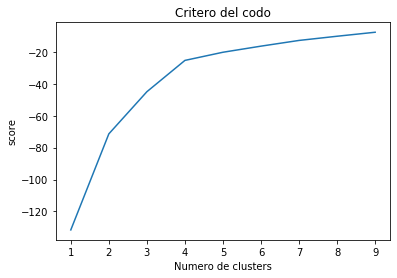

In [6]:
Nk= range(1,10)
X = np.array(desempleo[['Tasa de desocupación','Trimestre']])
kmeans = [KMeans(n_clusters = i) for i in Nk]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
fig2 = plt.figure()
plt.plot(Nk, score)
plt.xlabel('Numero de clusters')
plt.ylabel('score')
plt.title('Critero del codo')
plt.show()


Número optimo de clusters con Kmeans: De 2 donde se observa el la primera infelxion en la grafica, pero donde mayor tiene inflexion es con 4 clusters

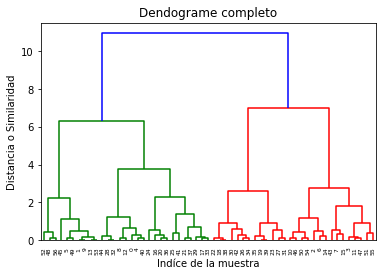

In [7]:
z = hierarchy.linkage(X,metric = 'euclidean', method = 'ward')
plt.title('Dendograme completo')
plt.xlabel('Indíce de la muestra')
plt.ylabel('Distancia o Similaridad')
dn=hierarchy.dendrogram(z)
plt.show()

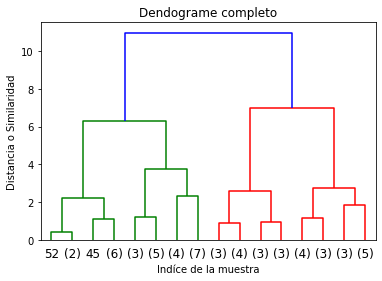

In [8]:
#%% Modificar el aspecto del dendograma
plt.figure()
plt.title('Dendograme completo')
plt.xlabel('Indíce de la muestra')
plt.ylabel('Distancia o Similaridad')
dn=hierarchy.dendrogram(z, truncate_mode='level',p=3)
plt.show()


Con el metodo del dendograma podemos ver que efectivamente se puede tener entre 2 y 4 clustrs

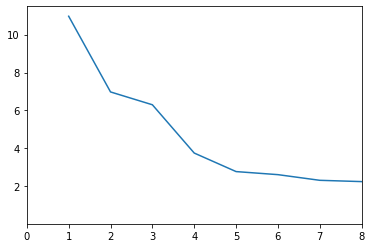

In [9]:
#%% Criterio del codo 
last = z[-20:,2]
last_rev=last[::-1]
idxs = np.arange(1,len(last_rev)+1)
plt.plot(idxs,last_rev)
plt.xlim(0,8)
plt.show()

El criterio del codo vemos los puntos 2 y 4 tienen mayor puntos de inflexion 

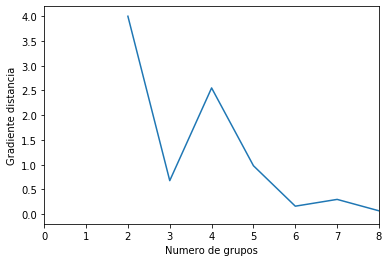

In [10]:
#%% Criterio del gradiente 
gradiente=np.diff(last)
grad_rev=gradiente[::-1]
plt.plot(idxs[1:],grad_rev)

plt.xlabel('Numero de grupos')
plt.ylabel('Gradiente distancia')
plt.xlim(0,8)
plt.show()

El criterio del gradente los matoes puntos son el 3 y 4 de número de gurpos optimos. 

## Uso de Kmeans para clustering

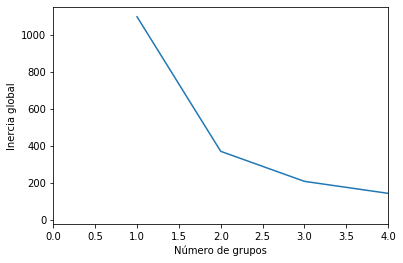

In [11]:
# CLustering K-means
inercias=np.zeros(20)

for k in np.arange(1,20):
    model=KMeans(n_clusters=k, random_state=42, init='k-means++')
    model=model.fit(desempleo)
    inercias[k]=model.inertia_
    
plt.plot(np.arange(1,20), inercias[1:])
plt.xlabel('Número de grupos')
plt.ylabel('Inercia global')
plt.xlim(0,4)
plt.show()

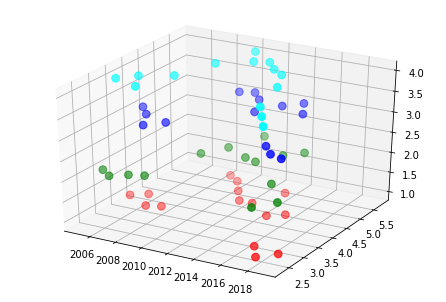

In [12]:
X= np.array(desempleo[['Año','Tasa de desocupación']])
y= np.array(desempleo['Trimestre'])

fig = plt.figure()
ax = Axes3D(fig)
colores = ['blue', 'red', 'green', 'blue', 'cyan']
asignar=[]

for row in y:
    asignar.append(colores[row])
ax.scatter(X[:,0], X[:,1],y, c=asignar, s=60)

In [13]:
# Aplicar PCA
scaler = StandardScaler()
scaler.fit(desempleo)
# Escalar datos y estandarizarlos
d_scaled = scaler.transform(desempleo)

In [14]:
# Ahora aplicamos PCA  con 3 componentes 
pca = PCA(n_components = 3) 
pca.fit(d_scaled) #Obtener las componentes principales
d_pca = pca.transform(d_scaled)
print (pca.explained_variance_ratio_.cumsum())

[0.4003439  0.71989234 1.        ]


In [15]:
print('tamaño de d_pca', d_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma', sum(expl[0:2]))

tamaño de d_pca (57, 3)
[0.4003439  0.31954844 0.28010766]
suma 0.7198923435395257


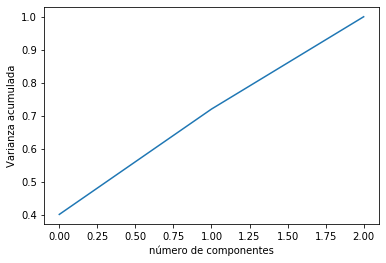

In [16]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('número de componentes')
plt.ylabel('Varianza acumulada')
plt.show()


## Regresión lineal con gradiente desendiente

In [17]:
X_df = pd.DataFrame(desempleo.Trimestre)
y_df = pd.DataFrame(desempleo['Tasa de desocupación'])
m= len(y_df)

Text(0, 0.5, 'Tasa de desocupacion')

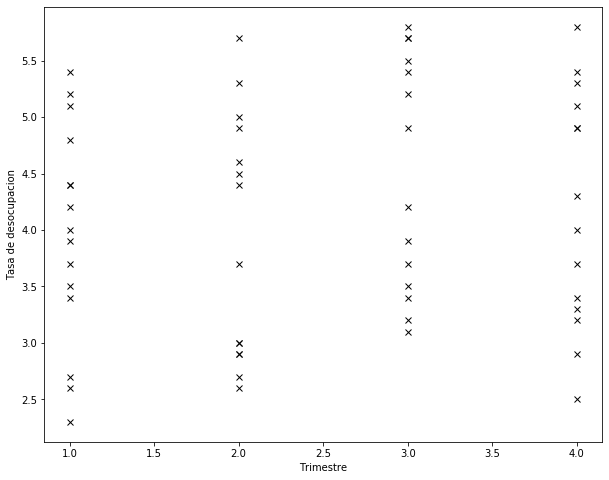

In [18]:
plt.figure(figsize=(10,8))
plt.plot(X_df, y_df, 'kx')
plt.xlabel('Trimestre')
plt.ylabel('Tasa de desocupacion')

In [19]:
iteration=1500
alpha = 0.01

X_df['intercept']=1

X=np.array(X_df)
y=np.array(y_df).flatten()
beta = np.array([0,0])



In [20]:
def cost_function(X, y, beta):
    ## numero de datos a entrenar
    m=len(y)
    #Calcular la funcion de costo
    J= np.sum(X.dot(beta))
    return J               


In [21]:
cost_function(X,y, beta)

0

In [22]:
def gradient_descent (X, y, beta, alpha, iterations):
    
    cost_history = [0]*iterations
    
    for iteration in range(iterations):
        y_hat = X.dot(beta)
        loss = y_hat - y
        gradient = X.T.dot(loss)/m
        beta = beta -alpha*gradient
        
        cost = cost_function (X,y, beta)
        cost_history[iteration]=cost
    
    return beta, cost_history

In [23]:
(beta, cost) = gradient_descent(X,y,beta,alpha,iteration)

#Imprimir valores de beta
print(beta)

[0.23863875 3.51026815]


In [24]:
# imprimir el modelo que mejor se ajusta a los datos

best_fit_x = np.linspace(0,25,20)
best_fit_y = [beta[1] + beta[0]*xx for xx in best_fit_x]

Text(0, 0.5, 'Tasa de desocupacion')

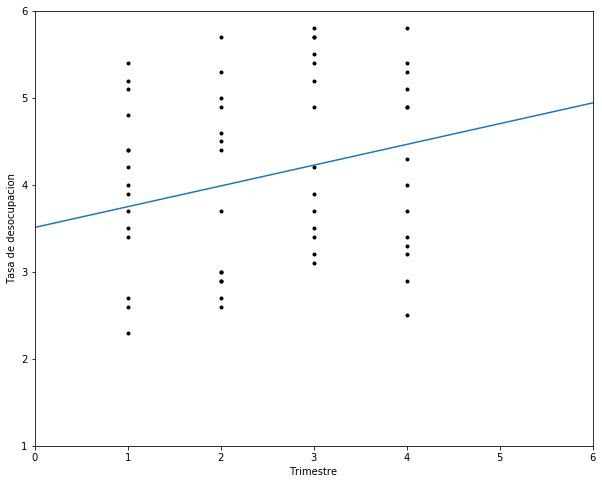

In [25]:
plt.figure(figsize=(10,8))
plt.plot(X_df.Trimestre, y_df, 'k.')
plt.plot(best_fit_x, best_fit_y, '-')
plt.axis([0,6,1,6])
plt.xlabel('Trimestre')
plt.ylabel('Tasa de desocupacion')

In [26]:
#predecir un valor de 4 
np.array([4,1]).dot(beta)


4.464823159607224

In [27]:
np.array([6,1]).dot(beta)

4.942100662062741

### Conlcusión 
- Nos podemos dar cuenta que la regresion linial no nos fuinciona para poder estimar las tasas de desocuápción por trimestre.

## Regresión Logistica

In [28]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import (accuracy_score,precision_score,
                             recall_score)

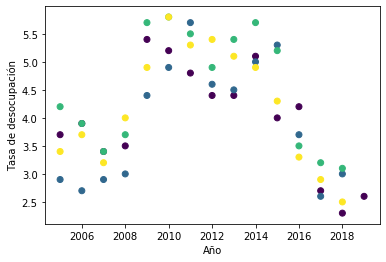

In [29]:
X = np.array(desempleo[['Año','Tasa de desocupación']])
Y = desempleo['Trimestre']
plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('Año')
plt.ylabel('Tasa de desocupación')
plt.show()

In [30]:
#peparacion del modelo de datos (crear el polinomio)
ngrado=7
poly = PolynomialFeatures(ngrado)
Xa = poly.fit_transform(X)
    

In [31]:
# Crear y entrenar la regresion logística c=1/lambda
modelo = linear_model.LogisticRegression(C=1e10)
modelo.fit(Xa,Y)
Yhat = modelo.predict(Xa)

In [32]:
#Evaluar al modelo

print(accuracy_score(Y,Yhat))
print(precision_score(Y,Yhat,average='weighted'))
print(recall_score(Y,Yhat,average='weighted'))



0.2807017543859649
0.14252753471768753
0.2807017543859649


C:\Users\aleja\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: 'c' argument has 57 elements, which is not acceptable for use with 'x' with size 2, 'y' with size 2.

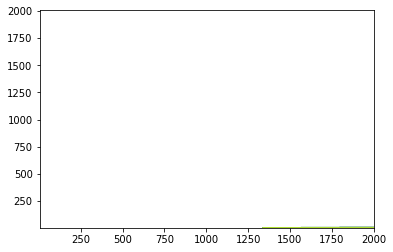

In [40]:
#%%visualizar la frontera de separacion

h=0.5

xmin, xmax, ymin, ymax = X[0].min(), X[0].max(), X[1].min(), X[1].max()

xx,yy = np.meshgrid(np.arange(xmin,xmax,h),np.arange(ymin,ymax,h))

Xnew = pd.DataFrame(np.c_[xx.ravel(),yy.ravel()])

Xa_new = poly.fit_transform(Xnew)

Z = modelo.predict(Xa_new)
Z=Z.reshape(xx.shape)

plt.contour(xx,yy,Z)
plt.scatter(X[0],X[1], c= Y)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.show()

## SVM

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model,svm
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score)
import pandas as pd

In [ ]:
X = desempleo.iloc[:,0:2]
Y = desempleo.iloc[:,2]

In [ ]:
#%% Crear y entrenar el modelo SVM
modelo_linear = svm.SVC(kernel='linear')
modelo_poly = svm.SVC(kernel='poly',degree=2)
modelo_rbf = svm.SVC(kernel='rbf')
modelo_linear.fit(X,Y)
modelo_poly.fit(X,Y)
modelo_rbf.fit(X,Y)

Yhat_svm_linear = modelo_linear.predict(X)
Yhat_svm_poly = modelo_poly.predict(X)
Yhat_svm_rbf = modelo_rbf.predict(X)

In [ ]:
Yhat_svm_linear = modelo_linear.predict(X)
Yhat_svm_poly = modelo_poly.predict(X)
Yhat_svm_rbf = modelo_rbf.predict(X)


accuracy_score(Y,Yhat_svm)

print('Accuracy : linear', accuracy_score(Y,Yhat_svm_linear))
print('Accuracy: poly', accuracy_score(Y,Yhat_svm_poly))
print('Accuracy: rbf', accuracy_score(Y,Yhat_svm_rbf))